In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt  # ✅ 누락된 부분
import seaborn as sns
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer  # KNN 보간

# ⚠️ FutureWarning 무시 (버전 호환성 이슈 방지용)
warnings.simplefilter(action='ignore', category=FutureWarning)

# ✅ 한글 폰트 설정 (Mac용 AppleGothic, Windows는 'Malgun Gothic')
rc('font', family='AppleGothic')

# ✅ 마이너스(-) 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv('../../data/raw/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              4376 non-null   object 
 1   설립연도            4376 non-null   int64  
 2   국가              4376 non-null   object 
 3   분야              3519 non-null   object 
 4   투자단계            4376 non-null   object 
 5   직원 수            4202 non-null   float64
 6   인수여부            4376 non-null   object 
 7   상장여부            4376 non-null   object 
 8   고객수(백만명)        3056 non-null   float64
 9   총 투자금(억원)       4376 non-null   float64
 10  연매출(억원)         4376 non-null   float64
 11  SNS 팔로워 수(백만명)  4376 non-null   float64
 12  기업가치(백억원)       3156 non-null   object 
 13  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 478.8+ KB


In [4]:
train['성공확률'].value_counts()

성공확률
0.7    590
0.6    579
0.3    574
0.4    561
0.5    559
0.8    548
0.1    490
0.9    475
Name: count, dtype: int64

In [5]:
test = pd.read_csv('../../data/raw/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   설립연도            1755 non-null   int64  
 2   국가              1755 non-null   object 
 3   분야              1401 non-null   object 
 4   투자단계            1755 non-null   object 
 5   직원 수            1679 non-null   float64
 6   인수여부            1755 non-null   object 
 7   상장여부            1755 non-null   object 
 8   고객수(백만명)        1208 non-null   float64
 9   총 투자금(억원)       1755 non-null   float64
 10  연매출(억원)         1755 non-null   float64
 11  SNS 팔로워 수(백만명)  1755 non-null   float64
 12  기업가치(백억원)       1268 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 178.4+ KB


# 전처리 함수

In [6]:
def preprocess(df):
    """
    주어진 데이터프레임에 대해 전처리 수행:
    - 결측치 처리
    - 인코딩
    - 매핑
    - 형변환 등
    """
    # 고객수, 기업가치의 결측치가 높으므로 KNN 보간법을 사용해본다.
    # 1. 설립연도: 그대로 사용 (패스)

    # 2. 국가: 원핫 인코딩
    df = pd.get_dummies(df, columns=['국가'])

    # 3. 분야: 결측치 → 'Unknown', 원핫 인코딩
    df['분야'].fillna('Unknown', inplace=True)
    df = pd.get_dummies(df, columns=['분야'])

    # 4. 투자단계: 수동 매핑
    investment_stage_order = {
        'Seed': 0,
        'Series A': 1,
        'Series B': 2,
        'Series C': 3,
        'IPO': 4
    }
    df['투자단계'] = df['투자단계'].map(investment_stage_order)

    # 5. 직원 수: 평균으로 대체
    mean_emp = df['직원 수'].mean()
    df['직원 수'].fillna(mean_emp, inplace=True)

    # 6. 인수여부, 상장여부: 원핫 인코딩
    df = pd.get_dummies(df, columns=['인수여부', '상장여부'])

    # 7. 고객수: 중앙값으로 대체
    # median_cust = df['고객수(백만명)'].median()
    # df['고객수(백만명)'].fillna(median_cust, inplace=True)
    if df['고객수(백만명)'].isnull().any():
        knn_imputer = KNNImputer(n_neighbors=5)
        scaler = MinMaxScaler()
    
        cust_array = df[['고객수(백만명)']].values.astype(float)
        cust_scaled = scaler.fit_transform(cust_array)
    
        cust_imputed_scaled = knn_imputer.fit_transform(cust_scaled)
        cust_imputed = scaler.inverse_transform(cust_imputed_scaled)
    
        df['고객수(백만명)'] = cust_imputed.flatten()

    # 8. 총 투자금, 연매출: 정수형 변환
    df['총 투자금(억원)'] = df['총 투자금(억원)'].astype(int)
    df['연매출(억원)'] = df['연매출(억원)'].astype(int)

    # 9. SNS 팔로워 수: 최빈값으로 대체
    mode_sns = df['SNS 팔로워 수(백만명)'].mode()[0]
    df['SNS 팔로워 수(백만명)'].fillna(mode_sns, inplace=True)

    # 10. 기업가치: 결측치 보완 + 수치 매핑
    df['기업가치(백억원)'].fillna('4500~6000', inplace=True)
    value_map = {
        '1500-2500': 2000,
        '2500-3500': 3000,
        '3500-4500': 4000,
        '4500-6000': 5250,
        '6000이상': 6500
    }
    df['기업가치(백억원)'] = df['기업가치(백억원)'].map(value_map)
#    df['기업가치(백억원)'].fillna(5250, inplace=True)  # 매핑 실패 보완
    # KNN 보간법으로 기업가치 결측치 보완
    if df['기업가치(백억원)'].isnull().any():
        knn_imputer = KNNImputer(n_neighbors=5)
        scaler = MinMaxScaler()

        # 2D 배열로 변환 후 스케일링
        value_array = df[['기업가치(백억원)']].values.astype(float)
        value_scaled = scaler.fit_transform(value_array)

        # KNN 보간
        value_imputed_scaled = knn_imputer.fit_transform(value_scaled)

        # 스케일 복원
        value_imputed = scaler.inverse_transform(value_imputed_scaled)

        # 보간 결과 원본에 반영
        df['기업가치(백억원)'] = value_imputed.flatten()
    
    return df

# 파생변수 생성

In [7]:
def add_features(df):
    # 1. 기업나이
    df['기업나이'] = 2025 - df['설립연도']

    # 2. 직원당 매출
    df['직원당매출'] = df['연매출(억원)'] / df['직원 수'].replace(0, np.nan)

    # 3. 고객당 매출
    df['고객당매출'] = df['연매출(억원)'] / df['고객수(백만명)'].replace(0, np.nan)

    # 4. 투자수익비
    df['투자수익비'] = df['연매출(억원)'] / df['총 투자금(억원)'].replace(0, np.nan)

    # 5. SNS 팔로워 등급
    df['SNS팔로워등급'] = pd.cut(df['SNS 팔로워 수(백만명)'],
                                 bins=[-1, 1, 3, 10],
                                 labels=[0, 1, 2])  # 낮음=0, 중간=1, 높음=2
    df['SNS팔로워등급'] = df['SNS팔로워등급'].astype(int)

    # 6. 가치대비매출 (기업가치 결측치 처리 포함)
    df['가치대비매출'] = df['기업가치(백억원)'] / df['연매출(억원)'].replace(0, np.nan)

    # 7. 총투자금당직원수
    df['총투자금당직원수'] = df['직원 수'] / df['총 투자금(억원)'].replace(0, np.nan)

    return df

# 스케일링 (MinMaxScaler, Log)

In [8]:
def scaleing(df):
    scale_cols = [
        '설립연도',
        '투자단계',
        '직원 수',
        '고객수(백만명)',
        '총 투자금(억원)',
        '연매출(억원)',
        'SNS 팔로워 수(백만명)',
        '기업가치(백억원)',
        '기업나이',
        '직원당매출',
        '고객당매출',
        '투자수익비',
        '가치대비매출',
        '총투자금당직원수',
        'SNS팔로워등급',
        #'성공확률'
    ]
    # 스케일링 적용
    scaler = MinMaxScaler()
    train[scale_cols] = scaler.fit_transform(train[scale_cols])
    
    # 타겟변수 로그 스케일링
    #train['성공확률'] = np.log(train['성공확률'])
    return df

In [9]:
def scaleing_for_test(df):
    '''
    검증 데이터에는 성공확률 컬럼이 없기 때문에 로그 변환 코드를 삭제함
    '''
    scale_cols = [
        '설립연도',
        '투자단계',
        '직원 수',
        '고객수(백만명)',
        '총 투자금(억원)',
        '연매출(억원)',
        'SNS 팔로워 수(백만명)',
        '기업가치(백억원)',
        '기업나이',
        '직원당매출',
        '고객당매출',
        '투자수익비',
        '가치대비매출',
        '총투자금당직원수',
        'SNS팔로워등급'
    ]
    # 스케일링 적용
    scaler = MinMaxScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols])

    return df

# 언더샘플링

In [10]:
from sklearn.utils import resample
import pandas as pd
    
def balance_by_target_sampling(df):
    # 성공확률 고유값별 최소 개수 찾기
    min_count = df['성공확률'].value_counts().min()
    
    # 각 성공확률 그룹별로 min_count 만큼 언더샘플링 후 합치기
    balanced_df = df.groupby('성공확률').apply(
        lambda x: resample(x, replace=False, n_samples=min_count, random_state=42)
    ).reset_index(drop=True)
    
    return balanced_df


# 최종 데이터 전처리 및 저장

In [11]:
train = preprocess(train)
train = add_features(train)
train = balance_by_target_sampling(train)
train = scaleing(train)

/var/folders/6v/5fx5m33x00dd03yh7nx0w9d80000gn/T/ipykernel_23844/1143587250.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('성공확률').apply(


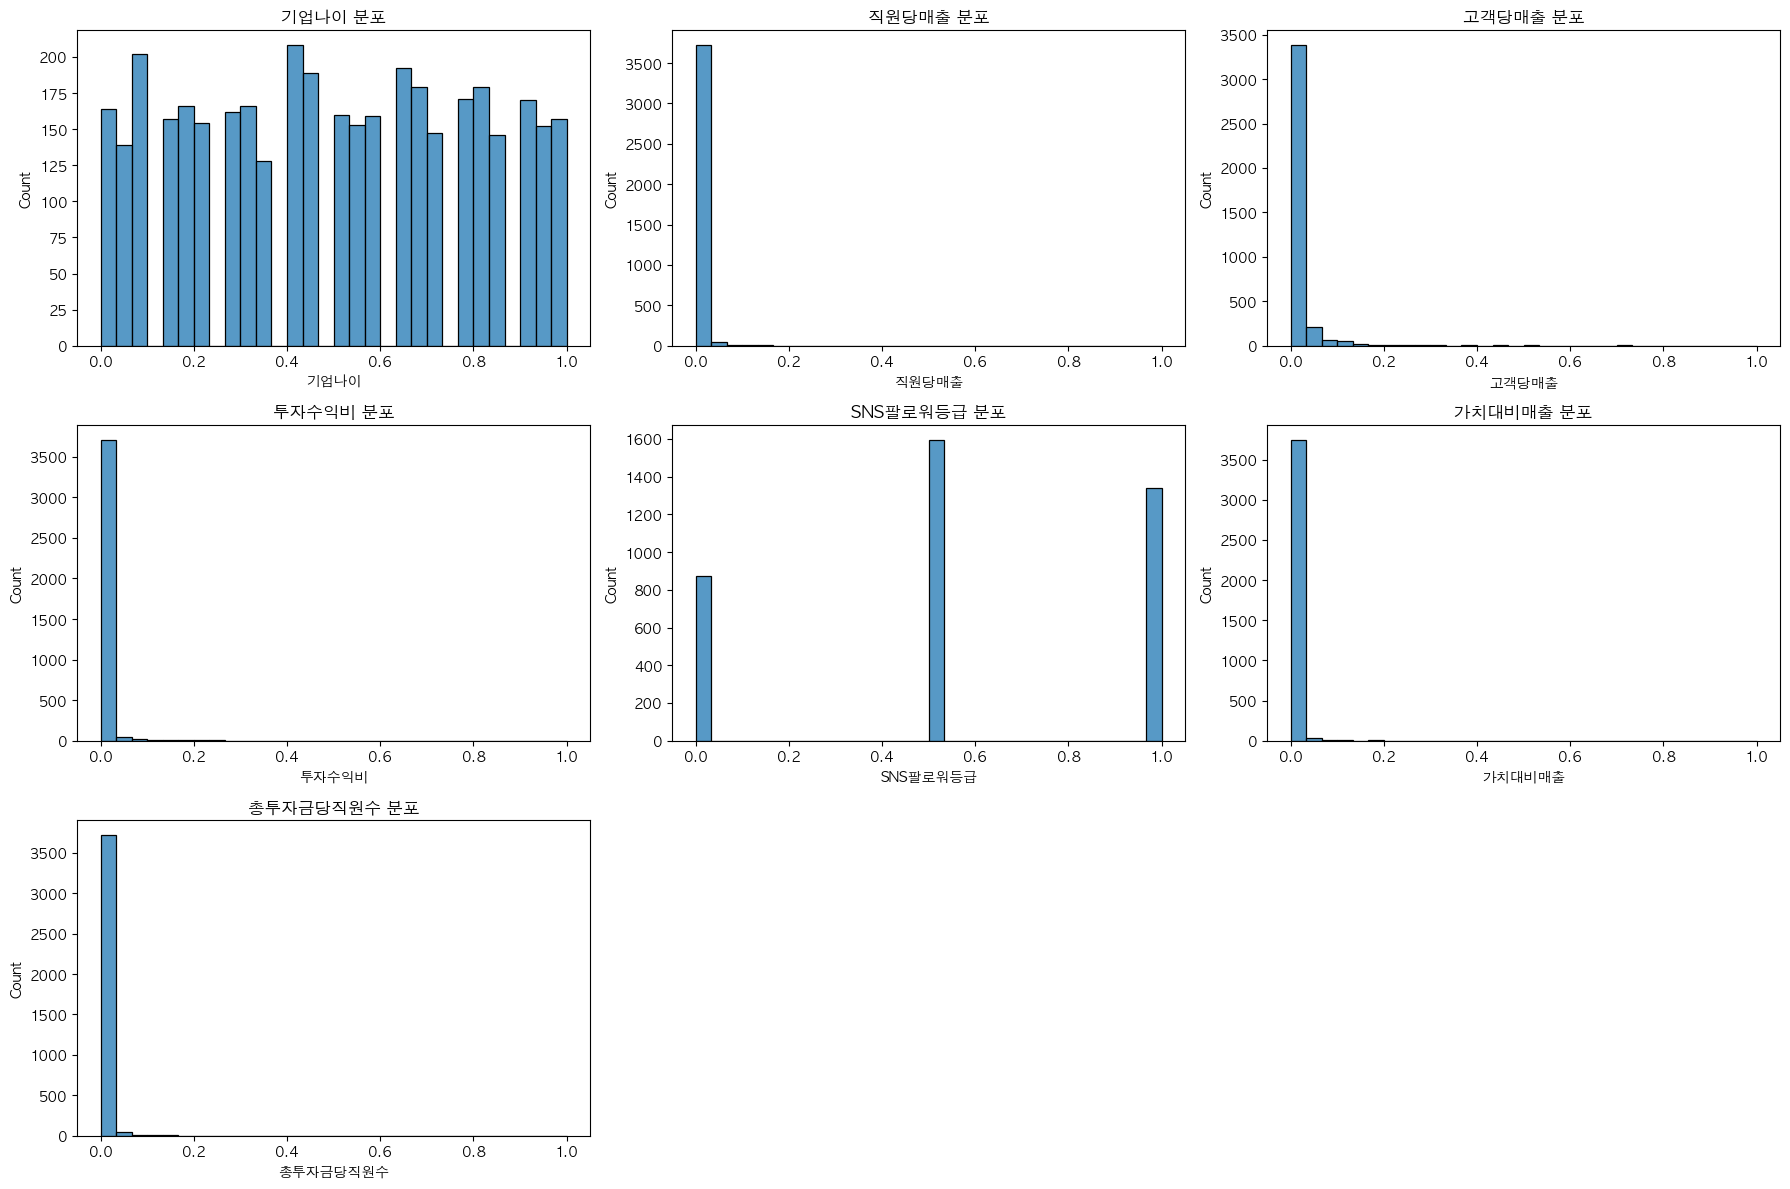

In [12]:
derived_cols = [
    '기업나이',
    '직원당매출',
    '고객당매출',
    '투자수익비',
    'SNS팔로워등급',
    '가치대비매출',
    '총투자금당직원수'
]

plt.figure(figsize=(18, 12))
for i, col in enumerate(derived_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(train[col].dropna(), kde=False, bins=30)
    plt.title(f'{col} 분포')
plt.tight_layout()
plt.show()

In [13]:
train['성공확률'].value_counts()

성공확률
0.1    475
0.3    475
0.4    475
0.5    475
0.6    475
0.7    475
0.8    475
0.9    475
Name: count, dtype: int64

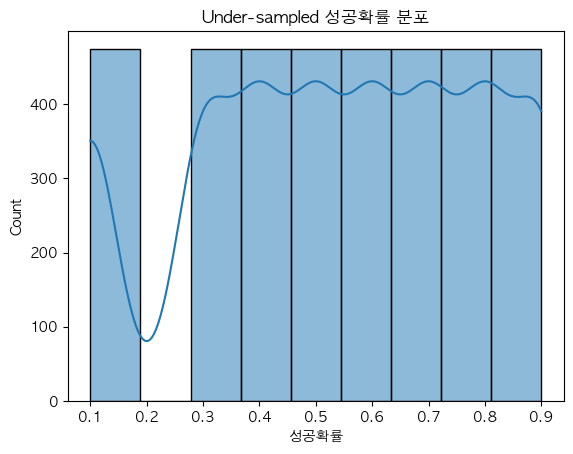

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train['성공확률'], bins=9, kde=True)
plt.title("Under-sampled 성공확률 분포")
plt.show()

In [15]:
train.head()

,ID,설립연도,투자단계,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,...,인수여부_Yes,상장여부_No,상장여부_Yes,기업나이,직원당매출,고객당매출,투자수익비,SNS팔로워등급,가치대비매출,총투자금당직원수
0,TRAIN_3959,0.909091,0.75,0.407170,0.112245,0.073081,0.318636,0.908,0.476429,0.1,...,False,True,False,0.090909,0.001406,0.035461,0.008842,1.0,0.001694,0.010105
1,TRAIN_0733,0.681818,0.75,0.609053,0.785714,0.233858,0.140176,0.400,1.000000,0.1,...,False,False,True,0.318182,0.000414,0.002390,0.001237,0.5,0.006809,0.004792
2,TRAIN_3824,0.454545,0.00,0.493956,0.491983,0.586491,0.855976,0.596,0.476429,0.1,...,False,True,False,0.545455,0.003112,0.023184,0.003014,0.5,0.000438,0.001554
3,TRAIN_4168,0.954545,0.25,0.363509,0.491983,0.168157,0.483930,0.854,0.476429,0.1,...,True,True,False,0.045455,0.002390,0.013109,0.005907,1.0,0.001011,0.003970
4,TRAIN_3771,0.772727,1.00,0.333267,0.491983,0.684972,0.153815,0.352,0.000000,0.1,...,True,True,False,0.227273,0.000830,0.004168,0.000464,0.5,0.001688,0.000897


In [16]:
train.describe()

,설립연도,투자단계,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,기업나이,직원당매출,고객당매출,투자수익비,SNS팔로워등급,가치대비매출,총투자금당직원수
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.00000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,0.501136,0.502961,0.493533,0.491409,0.471231,0.434193,0.516223,0.476469,0.53750,0.498864,0.005068,0.023337,0.006602,0.561316,0.004613,0.006147
std,0.298654,0.358600,0.284328,0.231860,0.266475,0.255047,0.283111,0.295951,0.24972,0.298654,0.025564,0.060704,0.035699,0.376219,0.031402,0.034317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227273,0.250000,0.250100,0.367347,0.236555,0.209504,0.270000,0.222222,0.37500,0.227273,0.000778,0.005859,0.000972,0.500000,0.000615,0.001002
50%,0.500000,0.500000,0.493956,0.491983,0.483894,0.433693,0.574000,0.476429,0.55000,0.500000,0.001553,0.011672,0.001911,0.500000,0.001169,0.001960
75%,0.772727,0.750000,0.735079,0.622449,0.694799,0.651452,0.800000,0.722222,0.72500,0.772727,0.003120,0.019920,0.003596,1.000000,0.002816,0.003744
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.90000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
test = preprocess(test)
test = add_features(test)
test = scaleing_for_test(test)

In [18]:
test.head()

,ID,설립연도,투자단계,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),국가_CT001,...,인수여부_Yes,상장여부_No,상장여부_Yes,기업나이,직원당매출,고객당매출,투자수익비,SNS팔로워등급,가치대비매출,총투자금당직원수
0,TEST_0000,0.045455,0.75,0.653028,0.448980,0.706330,0.476184,0.400,0.000000,False,...,False,False,True,0.954545,0.001019,0.012858,0.001752,0.5,0.000492,0.001638
1,TEST_0001,0.863636,0.75,0.742479,0.704082,0.224165,0.331500,0.840,0.466264,True,...,True,True,False,0.136364,0.000624,0.005749,0.003833,1.0,0.002381,0.005848
2,TEST_0002,0.590909,1.00,0.046330,0.897959,0.662343,0.662501,0.200,1.000000,False,...,True,False,True,0.409091,0.019614,0.009035,0.002600,0.0,0.001794,0.000124
3,TEST_0003,0.090909,0.00,0.126755,0.163265,0.300860,0.499393,1.000,0.000000,True,...,True,False,True,0.909091,0.005479,0.035722,0.004306,1.0,0.000447,0.000747
4,TEST_0004,0.227273,0.00,0.986161,0.683673,0.702665,0.541384,0.872,0.466264,False,...,True,True,False,0.772727,0.000767,0.009668,0.002003,1.0,0.001273,0.002487


In [19]:
test.describe()

,설립연도,투자단계,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),기업나이,직원당매출,고객당매출,투자수익비,SNS팔로워등급,가치대비매출,총투자금당직원수
count,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,0.494198,0.505698,0.497039,0.501411,0.457245,0.462029,0.507005,0.466264,0.505802,0.005473,0.018801,0.007956,0.554701,0.008120,0.006648
std,0.302361,0.355618,0.281365,0.229204,0.263459,0.270300,0.278924,0.292040,0.302361,0.038084,0.040763,0.034990,0.372401,0.049571,0.041441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227273,0.250000,0.262335,0.377551,0.228888,0.228701,0.253000,0.222222,0.227273,0.000628,0.005582,0.001386,0.500000,0.000814,0.000982
50%,0.500000,0.500000,0.497039,0.501411,0.466093,0.459616,0.512000,0.466264,0.500000,0.001297,0.010981,0.002613,0.500000,0.001491,0.001931
75%,0.772727,0.750000,0.737966,0.622449,0.673833,0.693601,0.800000,0.722222,0.772727,0.002645,0.018896,0.005184,1.000000,0.003608,0.003955
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
train.to_csv("../../data/processed/processed_train.csv", index=False)
test.to_csv("../../data/processed/processed_test.csv", index=False)

# 피쳐 중요도 확인

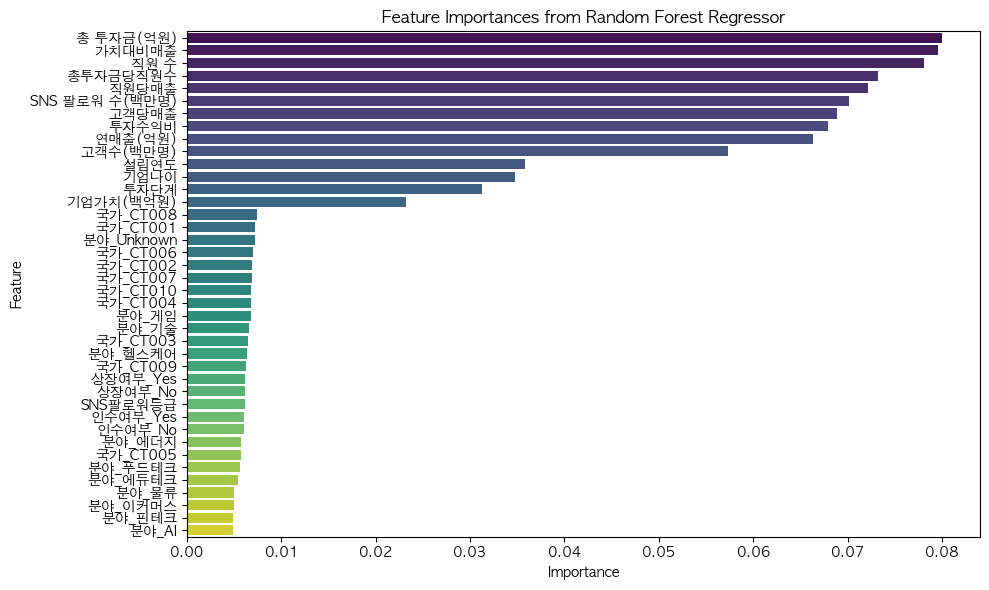

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 1. 데이터 불러오기
train = pd.read_csv('../../data/processed/processed_train.csv')
X = train.drop(columns=['성공확률', 'ID'])
y = train['성공확률']

# 2. 모델 정의 및 학습
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 3. 피처 중요도 추출
feature_importances = model.feature_importances_
feature_names = X.columns

# 4. 시각화를 위한 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 5. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from Random Forest Regressor')
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 3040, number of used features: 40
[LightGBM] [Info] Start training from score 0.541086


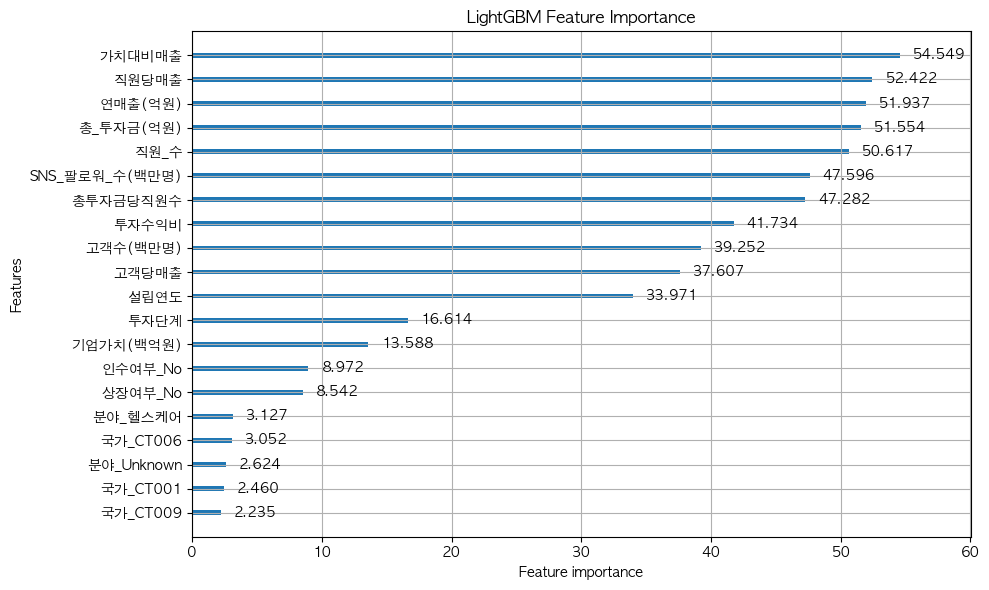

In [22]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# X, y 분리
X = train.drop(columns=['성공확률', 'ID'])
y = train['성공확률']

# 학습 데이터 분할 (성능 비교용, 여기선 전체 사용해도 무방)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 모델 정의
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# 피처 중요도 시각화
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

/var/folders/6v/5fx5m33x00dd03yh7nx0w9d80000gn/T/ipykernel_23844/758253214.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


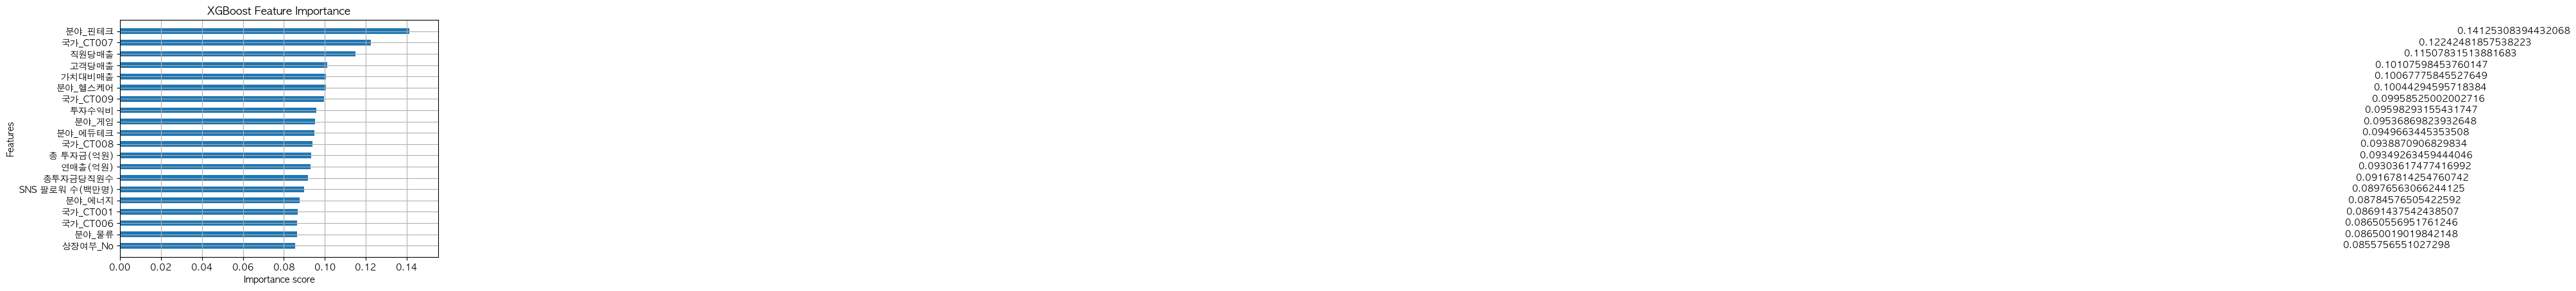

In [23]:
import xgboost as xgb
from xgboost import plot_importance

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X, y)

# 피처 중요도 시각화
plot_importance(xgb_model, importance_type='gain', max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# 🔍 세 모델 Feature Importance 비교 분석

## ✅ 공통된 핵심 피처
세 모델 모두 다음과 같은 **기업의 규모 및 성장성과 직결된 지표**들을 높은 중요도로 판단:

- `직원 수`
- `직원당매출`
- `가치대비매출`
- `SNS 팔로워 수`
- `연매출`
- `고객당매출`

또한, 투자 관련 지표들도 공통적으로 중요 피처로 판단됨:

- `총 투자금`
- `투자수`
- `투자단계`

---

## 📊 모델별 특이점

### 🌲 Random Forest Regressor
- 계량적 지표(수치형 변수)에 높은 중요도를 부여
- `직원 수`, `연매출`, `총 투자금` 등의 **정량적 피처**가 상위
- 범주형 변수는 상대적으로 중요도 낮게 평가됨

### 🌟 LightGBM
- Random Forest와 유사하게 **정량적 지표 중심**
- `가치대비매출`, `직원당매출` 등 **복합 계산 변수**도 중요하게 반영
- 빠른 학습과 높은 성능으로 직관적인 중요도 해석 가능

### ⚡ XGBoost
- **범주형 변수(국가, 산업군)**의 중요도가 상대적으로 높음
- 데이터셋 분할 방식 및 학습 방식(gain 기반)에 따라 결과가 달라질 수 있음
- **모델의 민감도**가 높은 편이므로 데이터 맥락 고려 필수

---

## 🧠 종합 의견

- **기업의 성장성 및 성과 예측**이 목적이라면,  
  `LightGBM`과 `Random Forest`가 강조한 **계량적 지표**가 보다 신뢰할 수 있는 핵심 변수로 판단됨.
  
- `XGBoost`는 범주형 변수의 영향도를 더 높게 평가하므로,  
  **산업군이나 국가와 같은 외생 변수**가 중요한 역할을 할 수 있는 분석에서 유용할 수 있음.

---

## 📌 결론

- 공통적으로 강조된 피처(`직원 수`, `SNS 팔로워 수`, `연매출` 등)는 실제 예측에도 핵심적인 역할을 할 가능성이 높음
- **모델별 강조 피처의 차이**는 예측 목적에 따라 고려될 수 있으며,  
  **앙상블 학습**이나 **피처 선택 전략**에 참고할 가치가 있음

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3800 non-null   object 
 1   설립연도            3800 non-null   float64
 2   투자단계            3800 non-null   float64
 3   직원 수            3800 non-null   float64
 4   고객수(백만명)        3800 non-null   float64
 5   총 투자금(억원)       3800 non-null   float64
 6   연매출(억원)         3800 non-null   float64
 7   SNS 팔로워 수(백만명)  3800 non-null   float64
 8   기업가치(백억원)       3800 non-null   float64
 9   성공확률            3800 non-null   float64
 10  국가_CT001        3800 non-null   bool   
 11  국가_CT002        3800 non-null   bool   
 12  국가_CT003        3800 non-null   bool   
 13  국가_CT004        3800 non-null   bool   
 14  국가_CT005        3800 non-null   bool   
 15  국가_CT006        3800 non-null   bool   
 16  국가_CT007        3800 non-null   bool   
 17  국가_CT008        3800 non-null   b

In [25]:
target_cols = ['ID','총 투자금(억원)','가치대비매출','직원 수','총투자금당직원수',
               '직원당매출','SNS 팔로워 수(백만명)',
               '고객당매출','투자수익비','연매출(억원)','고객수(백만명)',
               '설립연도','기업나이','투자단계','기업가치(백억원)','성공확률']

target_cols_for_test = ['ID','총 투자금(억원)','가치대비매출','직원 수','총투자금당직원수',
               '직원당매출','SNS 팔로워 수(백만명)',
               '고객당매출','투자수익비','연매출(억원)','고객수(백만명)',
               '설립연도','기업나이','투자단계','기업가치(백억원)']



In [26]:
feature_importance_train = train[target_cols]
feature_importance_test = test[target_cols_for_test]

In [27]:
feature_importance_train.to_csv("../../data/processed/feature_importance_train.csv", index=False)
feature_importance_test.to_csv("../../data/processed/feature_importance_test.csv", index=False)


In [28]:
feature_importance_train['성공확률'].value_counts()

성공확률
0.1    475
0.3    475
0.4    475
0.5    475
0.6    475
0.7    475
0.8    475
0.9    475
Name: count, dtype: int64

In [29]:
feature_importance_train[feature_importance_train['고객당매출'].isna()]

,ID,총 투자금(억원),가치대비매출,직원 수,총투자금당직원수,직원당매출,SNS 팔로워 수(백만명),고객당매출,투자수익비,연매출(억원),고객수(백만명),설립연도,기업나이,투자단계,기업가치(백억원),성공확률


In [30]:
feature_importance_train.head()

,ID,총 투자금(억원),가치대비매출,직원 수,총투자금당직원수,직원당매출,SNS 팔로워 수(백만명),고객당매출,투자수익비,연매출(억원),고객수(백만명),설립연도,기업나이,투자단계,기업가치(백억원),성공확률
0,TRAIN_3959,0.073081,0.001694,0.407170,0.010105,0.001406,0.908,0.035461,0.008842,0.318636,0.112245,0.909091,0.090909,0.75,0.476429,0.1
1,TRAIN_0733,0.233858,0.006809,0.609053,0.004792,0.000414,0.400,0.002390,0.001237,0.140176,0.785714,0.681818,0.318182,0.75,1.000000,0.1
2,TRAIN_3824,0.586491,0.000438,0.493956,0.001554,0.003112,0.596,0.023184,0.003014,0.855976,0.491983,0.454545,0.545455,0.00,0.476429,0.1
3,TRAIN_4168,0.168157,0.001011,0.363509,0.003970,0.002390,0.854,0.013109,0.005907,0.483930,0.491983,0.954545,0.045455,0.25,0.476429,0.1
4,TRAIN_3771,0.684972,0.001688,0.333267,0.000897,0.000830,0.352,0.004168,0.000464,0.153815,0.491983,0.772727,0.227273,1.00,0.000000,0.1


In [31]:
feature_importance_test.head()

,ID,총 투자금(억원),가치대비매출,직원 수,총투자금당직원수,직원당매출,SNS 팔로워 수(백만명),고객당매출,투자수익비,연매출(억원),고객수(백만명),설립연도,기업나이,투자단계,기업가치(백억원)
0,TEST_0000,0.706330,0.000492,0.653028,0.001638,0.001019,0.400,0.012858,0.001752,0.476184,0.448980,0.045455,0.954545,0.75,0.000000
1,TEST_0001,0.224165,0.002381,0.742479,0.005848,0.000624,0.840,0.005749,0.003833,0.331500,0.704082,0.863636,0.136364,0.75,0.466264
2,TEST_0002,0.662343,0.001794,0.046330,0.000124,0.019614,0.200,0.009035,0.002600,0.662501,0.897959,0.590909,0.409091,1.00,1.000000
3,TEST_0003,0.300860,0.000447,0.126755,0.000747,0.005479,1.000,0.035722,0.004306,0.499393,0.163265,0.090909,0.909091,0.00,0.000000
4,TEST_0004,0.702665,0.001273,0.986161,0.002487,0.000767,0.872,0.009668,0.002003,0.541384,0.683673,0.227273,0.772727,0.00,0.466264
